<a href="https://colab.research.google.com/github/BennV012/Projects/blob/main/Copie_de_ML_TPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import os
from tensorflow.keras import layers

Checking our images

In [ ]:
## images path
path = pathlib.Path("/content/drive/MyDrive/Cours HEC/Maitrise/Semestre 2/Machine_Learning/TP GROUPE/book_covers/")
#path = pathlib.Path("/content/drive/MyDrive/TP GROUPE/TP GROUPE/TP GROUPE/book_covers/")#Benoit Vanier
image_count=len(list(path.glob('*/*.jpg')))
print(image_count)

16587


Because there are some corrupt images we need to run the following code (once) to delete them

In [ ]:
def check_image(fn):
    file_contents = tf.io.read_file(fn)
    image = tf.image.decode_jpeg(file_contents, channels=3)
    try:
        file_contents = tf.io.read_file(fn)
        image = tf.image.decode_jpeg(file_contents, channels=3)
    except:
        print("error",fn)

In [ ]:
bads = []
num_skipped = 0

for folder_name in ('Thriller', 'children', 'romance', 'science_fiction'):
    folder_path = os.path.join(path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            # uncoment to run and delete corrupt files,  very slow !
            #check_image(fpath)
        except:
            bads.append(fpath)
            num_skipped += 1
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # add corrupted image to bads
            bads.append(fpath)

print("We have to delete %d images" % num_skipped)

Checking a childrens book

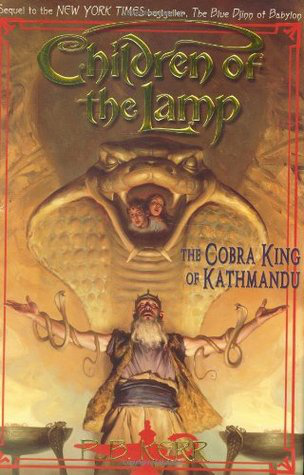

In [ ]:
children = list(path.glob('children/*'))
PIL.Image.open(str(children[12]))

Creating a dataset

In [ ]:
batch_size =32
img_height = 156
img_width =100
train_img =tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=80629,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 16580 files belonging to 4 classes.
Using 13264 files for training.


In [ ]:
valid_img =tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=80629,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 16580 files belonging to 4 classes.
Using 3316 files for validation.


Classes

In [ ]:
class_names = train_img.class_names
print(class_names)

['Thriller', 'children', 'romance', 'science_fiction']


Visualisation

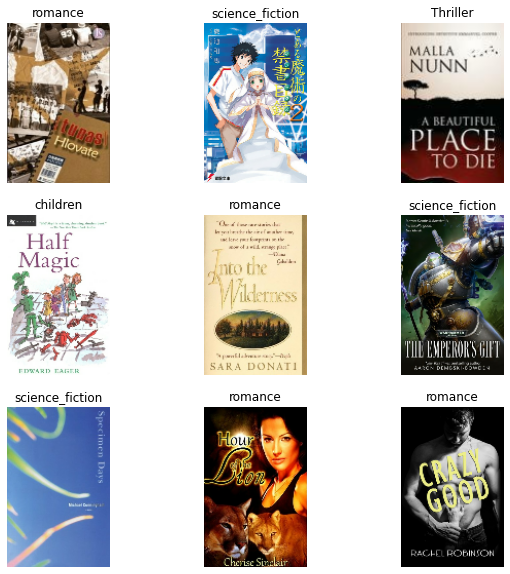

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_img.take(1):
  for i in range(9):
    ax:plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Size off the data

In [ ]:
for image_batch, labels_batch in train_img:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 156, 100, 3)
(32,)


Standardisation

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

Setting the model

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_img = train_img.cache().prefetch(buffer_size=AUTOTUNE)
valid_img = valid_img.cache().prefetch(buffer_size=AUTOTUNE)

num_classes=4

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Training

In [ ]:
model.fit(
    train_img,
    validation_data=valid_img,
    epochs=3
)

Epoch 1/3
415/415 [==============================] - 70s 164ms/step - loss: 1.3081 - accuracy: 0.3699 - val_loss: 1.2389 - val_accuracy: 0.4264
Epoch 2/3
415/415 [==============================] - 6s 16ms/step - loss: 1.2247 - accuracy: 0.4383 - val_loss: 1.2074 - val_accuracy: 0.4539
Epoch 3/3
415/415 [==============================] - 6s 16ms/step - loss: 1.1570 - accuracy: 0.4896 - val_loss: 1.1954 - val_accuracy: 0.4536


Saving our model after 3 iterations

In [ ]:
model_3 = model